<a href="https://colab.research.google.com/github/getChan/data_campus/blob/master/NLP/CNN_Text_Classification_(Full).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Text Classification Lab

## Goal
본 실습의 목표는 Convolutional Neural Network을 이용하여 문장을 여러 카테고리 중 하나로 분류하는 모델을 만드는 것입니다. 또한, 미리 학습된 단어 벡터를 모델에 적용하는 방법도 배워볼 것입니다.

## Dataset

학습 데이터는 Stanford 대학에서 구성한 공손함 데이터를 사용하겠습니다.

In [2]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip

--2019-08-05 04:00:50--  http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34676352 (33M) [application/zip]
Saving to: ‘Stanford_politeness_corpus.zip’

Stanford_politeness 100%[===================>]  33.07M  8.12MB/s    in 4.3s    

2019-08-05 04:00:55 (7.72 MB/s) - ‘Stanford_politeness_corpus.zip’ saved [34676352/34676352]

Archive:  Stanford_politeness_corpus.zip
   creating: Stanford_politeness_corpus/
  inflating: Stanford_politeness_corpus/Readme.txt  
  inflating: Stanford_politeness_corpus/stack-exchange.annotated.csv  
  inflating: Stanford_politeness_corpus/stack-exchange.requests.csv  
  inflating: Stanford_politeness_corpus/stack-exchange.roles.csv  
  inflating: Stanford_politeness_corpus/wikipedia.admins.csv  
  inflating: Stanford_

In [0]:
def load_data(data_file):
  data = pd.read_csv(data_file)

  # Only use the top quartile as polite, and bottom quartile as impolite. Discard the rest.
  quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
  print(quantiles)

  for i in range(len(data)):
    score = data.loc[i, "Normalized Score"]
    if score <= quantiles[0.25]:
      # Bottom quartile (impolite).
      data.loc[i, "Normalized Score"] = 0
    elif score >= quantiles[0.75]:
      # Top quartile (polite).
      data.loc[i, "Normalized Score"] = 1
    else:
      # Neutral.
      data.loc[i, "Normalized Score"] = 2

  data["Normalized Score"] = data["Normalized Score"].astype(int)

  # Discard neutral examples.
  data = data[data["Normalized Score"] < 2]
  data = data.sample(frac=1).reset_index(drop=True)

  return data

In [5]:
data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)

print(data.head())

0.25   -0.442633
0.50    0.052339
0.75    0.514399
Name: Normalized Score, dtype: float64
   Community      Id                                            Request  \
0  Wikipedia  627023  You just added it again. Maybe you should look...   
1  Wikipedia  559576  Thanks for nuking that thing. While the page w...   
2  Wikipedia  115796  I like the image of the Finnish lighthouses. D...   
3  Wikipedia  204594                                             Who???   
4  Wikipedia  625172  No worries. Can you take another look at the nom?   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      14       5      13      14       5  A22SZHZTF72TRM   A6YO9886DY2SC   
1      21      17      19      16      17  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
2      17      21      13      17      25  A2UFD1I8ZO1V4G  A1W2G1N4BDF2DW   
3       9      10      13      13       9  A233ONYNWKDIYF   AYG3MF094634L   
4      17      22      21      16      13  A233ONYNWKDIYF  A1JMINVUZ2AOZR 

다음으로 할 일은 사전을 구성하는 것입니다.


신경망의 입력으로 사용하기 위해서는 문장을 숫자로 바꿔야 하는데, 사전의 역할은 단어를 숫자로, 숫자를 단어로 바꿔주는 것입니다.

여기서 빠른 계산을 위해 dictionary 자료 구조를 사용하는 것이 일반적입니다.



1.   문장들을 소문자로 바꾸고, tokenization (nltk.tokenize 패키지의 word_tokenize  함수 활용)
2.   전체 데이터에서 각 토큰들의 등장 빈도 확인 (collections 패키지의 Counter  클래스 활용)
3.   가장 등장 빈도가 높은 단어를 vocab_size 만큼 선택 (Counter의 most_common 함수 활용)
4.   각각의 단어에 고유한 숫자 부여. 이때, 0번째 토큰은 "<PAD>", 1번째 토큰은 "<OOV>" 할당
5.   토큰 -> 숫자 변환을 위한 dictionary (word_index 변수에 할당)와, 숫자 -> 토큰 변환을 위한 dictionary (word_inverted_index 변수에 할당) 생성
  
  



In [6]:
vocab_size = 5000
# we assign the first indices in the vocabulary to special tokens that we use
# for padding, and for indicating unknown words
pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
  word_counter = Counter()

  for sent in sentences:
    tokens = word_tokenize(sent.lower())
    word_counter.update(tokens)
  
  most_common = word_counter.most_common()
  print("고빈도 단어:")
  for k, v in most_common[:10]:
    print(k, ": ", v)
  
  vocab = {
      '<PAD>': pad_id,
      '<OOV>': oov_id
  }
  for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
    vocab[word] = i
    if len(vocab) >= vocab_size:
      break
  
  return vocab
  
sentences = data["Request"].tolist()
word_index = make_vocab(sentences)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
  print(i, word_inverted_index[i])
  
print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
? :  2714
the :  2499
you :  2235
, :  2204
to :  1695
i :  1679
. :  1642
a :  1125
it :  963
that :  936

단어 사전:
0 <PAD>
1 <OOV>
2 ?
3 the
4 you
5 ,
6 to
7 i
8 .
9 a

단어 사전 크기:  5000


사전이 잘 구성되었는지 시험해보겠습니다. 

사전이 잘 구성되고, 각각의 사전이 word_index 변수와 word_inverted_index 변수에 할당되었다면 문장이 숫자로 변환되었다가 다시 원래 문장으로 돌아오는 것을 확인하실 수 있습니다.

In [7]:
def index_to_text(indexes):
  return ' '.join([word_inverted_index[i] for i in indexes])
  
def text_to_index(text):
  tokens = tokens = word_tokenize(text.lower())
  indexes = []
  for tok in tokens:
    if tok in word_index:
      indexes.append(word_index[tok])
    else:
      indexes.append(oov_id)
      
  return indexes

print("원본: ", sentences[0])
ids = text_to_index(sentences[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  You just added it again. Maybe you should look over the guidelines for inclusion of the tag?
문자 -> 숫자:  [4, 57, 177, 10, 123, 8, 197, 4, 60, 102, 153, 3, 919, 19, 805, 12, 3, 271, 2]
숫자 -> 문자:  you just added it again . maybe you should look over the guidelines for inclusion of the tag ?


다음으로, 숫자로 바뀐 문장들을 학습 데이터로 사용할 수 있도록 변형하겠습니다.



1.   모든 문장들을 동일한 길이가 되도록 padding 처리하거나 자름 (tensorflow.python.keras.preprocessing.sequence 패키지의 pad_sequence 함수 활용)
2.   데이터의 일부(10%)를 테스트 데이터로 분리



In [8]:
x_variable = [text_to_index(sent) for sent in sentences]

sentence_size = 200
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

n_test = len(data) // 10
test_inputs = x_padded[:n_test]
train_inputs = x_padded[n_test:]

ys = np.array(data["Normalized Score"].tolist())
test_labels = ys[:n_test]
train_labels = ys[n_test:]

print("test_inputs shape: ", test_inputs.shape)
print("train_inputs shape: ", train_inputs.shape)
print("test_labels shape: ", test_labels.shape)
print("train_labels shape: ", train_labels.shape)

test_inputs shape:  (217, 200)
train_inputs shape:  (1961, 200)
test_labels shape:  (217,)
train_labels shape:  (1961,)


이제 모델을 설계할 차례입니다. 

keras.Sequential을 이용하여 CNN 모델을 구성해봅시다. Sequential 모델을 사용하려면 동일한 크기의 필터만 사용할 수 있습니다.

참고 함수: 

keras.layers.Embedding

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

keras.layers.Conv1D

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

keras.layers.GlobalMaxPool1D

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D

keras.layers.Dense

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense



In [9]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

W0805 04:01:02.390763 139917669115776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 04:01:02.393389 139917669115776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


아래는 학습 결과를 시각화해주고, 성능을 측정하는 함수들입니다.

In [0]:
def plot_loss(history):
  plt.figure(figsize=(6,5))
  val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
  plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  
def eval_model(model):
  test_loss, test_acc = model.evaluate(test_inputs, test_labels)
  print('Test accuracy:', test_acc)

만들어진 모델을 학습시켜보겠습니다.

Train on 1961 samples, validate on 217 samples
Epoch 1/10
1961/1961 [==============================] - 4s 2ms/sample - loss: 0.6766 - acc: 0.6328 - val_loss: 0.6475 - val_acc: 0.7512
Epoch 2/10
1961/1961 [==============================] - 0s 98us/sample - loss: 0.5655 - acc: 0.8307 - val_loss: 0.5432 - val_acc: 0.7558
Epoch 3/10
1961/1961 [==============================] - 0s 105us/sample - loss: 0.4186 - acc: 0.8730 - val_loss: 0.4652 - val_acc: 0.7972
Epoch 4/10
1961/1961 [==============================] - 0s 104us/sample - loss: 0.3012 - acc: 0.9138 - val_loss: 0.4236 - val_acc: 0.8111
Epoch 5/10
1961/1961 [==============================] - 0s 98us/sample - loss: 0.2141 - acc: 0.9459 - val_loss: 0.3862 - val_acc: 0.8203
Epoch 6/10
1961/1961 [==============================] - 0s 100us/sample - loss: 0.1437 - acc: 0.9725 - val_loss: 0.3784 - val_acc: 0.8295
Epoch 7/10
1961/1961 [==============================] - 0s 100us/sample - loss: 0.0950 - acc: 0.9847 - val_loss: 0.3705 - val_acc

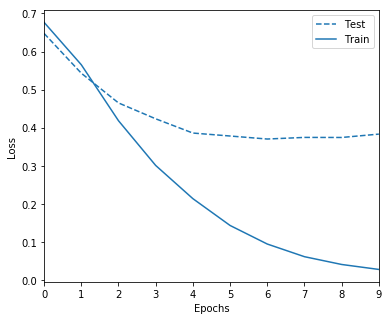

In [11]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

## Pretrained word vectors

이번에는 만들어진 모델에 미리 학습된 단어 벡터를 적용해보겠습니다.

단어 벡터는 GloVe 벡터를 사용할 것입니다.

벡터 파일을 다운로드 받고 압축을 풀어보겠습니다.

파일이 어떻게 구성되어 있는지 볼까요?

In [12]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip
    
! head glove.6B.50d.txt

--2019-08-05 04:01:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-05 04:01:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-05 04:01:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

GloVe 벡터를 불러와서 임베딩 행렬을 초기화해보겠습니다.



1.   GloVe 파일을 읽고, 각 줄에서 단어(1번째 토큰)와 벡터를 이루는 숫자들(2번째 이후 토큰들)을 분리
2.   벡터를 이루는 숫자들을 numpy 행렬로 변환 (numpy의 asarray 함수 활용)
3.   단어와 벡터를 연결하는 dictionary 자료구조 구성 (단어 -> 벡터)
4.   모든 단어들에 대한 임베딩 행렬을 무작위로 생성 (vocab_size X 50 크기의 numpy 행렬)
5.   임베딩 행렬에서, GloVe 벡터가 존재하는 단어들만 해당 GloVe 벡터로 대체



In [13]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, 50))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4429/5000 words.


앞서 사용된 모델에서, Embedding layer의 값을 위에서 생성한 임베딩 행렬로 초기화해봅시다.

(keras.initializers.Constant 클래스 활용)


In [0]:
glove_init = keras.initializers.Constant(embedding_matrix)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Train on 1961 samples, validate on 217 samples
Epoch 1/10
1961/1961 [==============================] - 0s 163us/sample - loss: 0.6854 - acc: 0.5660 - val_loss: 0.6584 - val_acc: 0.5945
Epoch 2/10
1961/1961 [==============================] - 0s 105us/sample - loss: 0.5511 - acc: 0.7343 - val_loss: 0.5951 - val_acc: 0.6544
Epoch 3/10
1961/1961 [==============================] - 0s 108us/sample - loss: 0.4595 - acc: 0.8302 - val_loss: 0.5485 - val_acc: 0.7143
Epoch 4/10
1961/1961 [==============================] - 0s 111us/sample - loss: 0.3824 - acc: 0.8746 - val_loss: 0.5075 - val_acc: 0.7558
Epoch 5/10
1961/1961 [==============================] - 0s 105us/sample - loss: 0.3098 - acc: 0.9204 - val_loss: 0.4621 - val_acc: 0.7650
Epoch 6/10
1961/1961 [==============================] - 0s 105us/sample - loss: 0.2524 - acc: 0.9449 - val_loss: 0.4348 - val_acc: 0.7926
Epoch 7/10
1961/1961 [==============================] - 0s 106us/sample - loss: 0.2086 - acc: 0.9597 - val_loss: 0.4151 - val

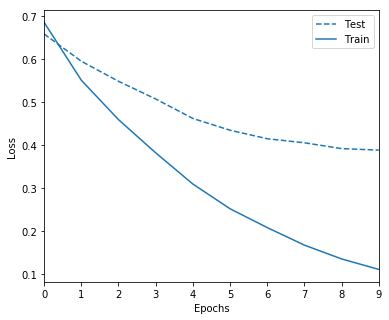

In [15]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)